# An example of masterplan creation

In [1]:
import networkx as nx
import geopandas as gpd
from IPython.display import Image, display
import matplotlib.pyplot as plt

from masterplan_tools.City_model.city_model import CityModel
from masterplan_tools.Provision_getter.provision_getter import ProvisionModel
from masterplan_tools.Balancer.balancer import MasterPlan, balance_data
from masterplan_tools.Data_getter.data_getter import DataGetter

/home/gk/jupyter/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### City model creation

In [2]:
# path to data
path = "../masterplanning/mp_data/"

# load data required for blocks creation
city_geometry = gpd.read_parquet(path + "city_geometry.parquet")
water_geometry = gpd.read_parquet(path + "water_geometry.parquet")
roads_geometry = gpd.read_parquet(path + "roads_geometry.parquet")
railways_geometry = gpd.read_parquet(path + "railways_geometry.parquet")
nature_geometry_boundaries = gpd.read_parquet(path + "nature_geometry_boundaries.parquet")

# load data required for service graphs creation
schools = gpd.read_parquet(path + "schools.parquet")
kindergartens = gpd.read_parquet(path + "kindergartens.parquet")
recreational_areas = gpd.read_parquet(path + "recreational_areas.parquet")
# accessibility_matrix = pd.read_pickle(path + "accessibility_matrix.pkl")

# load data required for
buildings = gpd.read_parquet(path + "buildings.parquet")
greenings = gpd.read_parquet(path + "greenings.parquet")
parkings = gpd.read_parquet(path + "parkings.parquet")

transport_graph = nx.read_graphml(path + "new_graph.graphml")

# data loading with planning area
polygon = gpd.read_file(path + "polygon.geojson")

In [3]:
# services should be specified as a dictionary
services = {"schools": schools, "kindergartens": kindergartens, "recreational_areas": recreational_areas}

In [4]:
# City data model creation
city_model = CityModel(
    services=services,
    city_geometry=city_geometry,
    water_geometry=water_geometry,
    roads_geometry=roads_geometry,
    railways_geometry=railways_geometry,
    nature_geometry_boundaries=nature_geometry_boundaries,
    # accessibility_matrix=accessibility_matrix,
    transport_graph=transport_graph,
    buildings=buildings,
    greenings=greenings,
    parkings=parkings,
)

100%|██████████| 151/151 [00:00<00:00, 354.38it/s]


#### Calculating the provision of services in blocks

In [5]:
services_prov = {}

for service_type in services.keys():
    provision = ProvisionModel(city_model=city_model, service_name=service_type)
    print(service_type)
    services_prov[service_type] = provision.run()

schools
Number of blocks with service: schools: 28
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0

kindergartens
Number of blocks with service: kindergartens: 32
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0

recreational_areas
Number of blocks with service: recreational_areas: 151
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0



In [6]:
kindergartens = services_prov["kindergartens"]["population"]

#### Service provision visualization

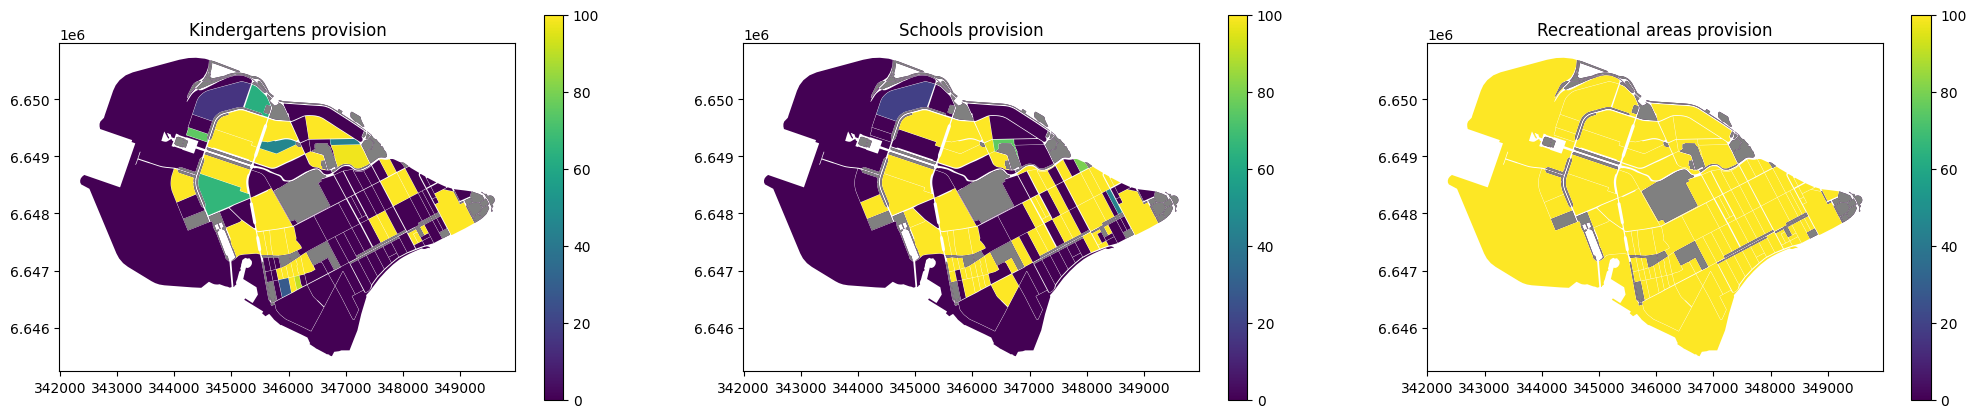

In [7]:
kindergartens_prov = services_prov["kindergartens"]
schools_prov = services_prov["schools"]
recreational_areas_prov = services_prov["recreational_areas"]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
kindergartens_prov.plot(column="provision_kindergartens", legend=True, ax=ax1)
ax1.set_title("Kindergartens provision")
schools_prov.plot(column="provision_schools", legend=True, ax=ax2)
ax2.set_title("Schools provision")
recreational_areas_prov.plot(column="provision_recreational_areas", legend=True, ax=ax3)
ax3.set_title("Recreational areas provision")

kindergartens_prov[kindergartens_prov["population"] == 0].plot(ax=ax1, color="grey", alpha=1)
schools_prov[schools_prov["population"] == 0].plot(ax=ax2, color="grey", alpha=1)
recreational_areas_prov[recreational_areas_prov["population"] == 0].plot(ax=ax3, color="grey", alpha=1)

plt.show()

#### Selected area of the city to which the new parameters will be modelled

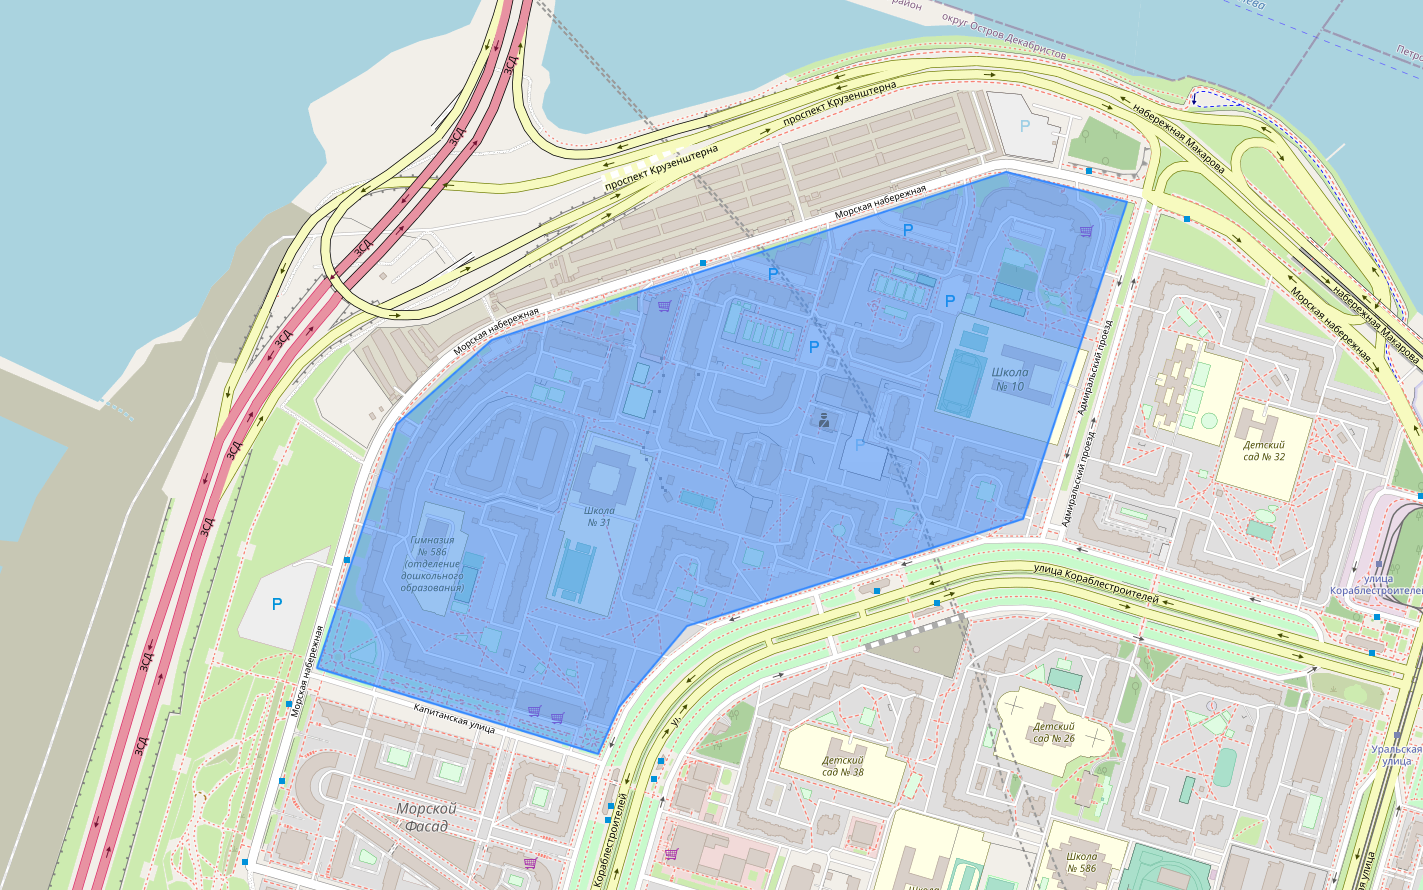

In [8]:
display(Image(filename="../masterplanning/img/polygon.png", embed=True))

In [9]:
block = balance_data(
    gdf=city_model.blocks_aggregated_info,
    polygon=polygon,
    school=services_prov["schools"],
    kindergarten=services_prov["kindergartens"],
    greening=services_prov["recreational_areas"],
)

In [10]:
block

{'block_id': 24.0,
 'area': 39.81881724414382,
 'current_living_area': 5.0037369,
 'current_industrial_area': 1.3555672700000003,
 'current_population': 14424.0,
 'current_green_area': 1.0476,
 'floors': 4.0,
 'population_unprov_schools': 11665.0,
 'population_unprov_kindergartens': 12194.0,
 'population_unprov_recreational_areas': 0.0}

In [11]:
from IPython.display import Markdown, display

markdown_table = "| Option | Techno-economic indicator |\n| --- | --- |\n"
for key, value in block.items():
    markdown_table += f"| {key} | {round(value)} |\n"

display(Markdown(markdown_table))

| Option | Techno-economic indicator |
| --- | --- |
| block_id | 24 |
| area | 40 |
| current_living_area | 5 |
| current_industrial_area | 1 |
| current_population | 14424 |
| current_green_area | 1 |
| floors | 4 |
| population_unprov_schools | 11665 |
| population_unprov_kindergartens | 12194 |
| population_unprov_recreational_areas | 0 |


#### Modelling of new parameters for the selected area with maximisation of the number of inhabitants

In [12]:
mp = MasterPlan(
    area=block["area"],
    current_living_area=block["current_living_area"],
    current_industrial_area=block["current_industrial_area"],
    current_population=block["current_population"],
    current_green_area=block["current_green_area"],
    current_unprov_schoolkids=block["population_unprov_schools"],
    current_unprov_kids=block["population_unprov_kindergartens"],
    current_unprov_green_population=block["population_unprov_recreational_areas"],
)

updated_block = mp.optimal_solution_indicators()
updated_block["block_id"] = 24

/home/gk/jupyter/masterplanning/masterplan_tools/Balancer/balancer.py:408: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(temp_result, ignore_index=True)
/home/gk/jupyter/masterplanning/masterplan_tools/Balancer/balancer.py:408: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(temp_result, ignore_index=True)
/home/gk/jupyter/masterplanning/masterplan_tools/Balancer/balancer.py:408: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(temp_result, ignore_index=True)
/home/gk/jupyter/masterplanning/masterplan_tools/Balancer/balancer.py:408: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

#### Modelled block transformation requirements

In [13]:
from IPython.display import Markdown, display

markdown_table = "| Option | Techno-economic indicator |\n| --- | --- |\n"
for key, value in updated_block.items():
    markdown_table += f"| {key} | {round(value)} |\n"

display(Markdown(markdown_table))

| Option | Techno-economic indicator |
| --- | --- |
| area | 40 |
| population | 18807 |
| b | 30 |
| green_coef_G | 6 |
| living_area | 18 |
| schools_area | 4 |
| schools_capacity | 2200 |
| kindergartens_area | 1 |
| kindergartens_capacity | 180 |
| green_area | 4 |
| G_min_capacity | 6129 |
| G_max_capacity | 3065 |
| green_coef_G_capacity | 6129 |
| op_area | 0 |
| parking1_area | 3 |
| parking2_area | 3 |
| block_id | 24 |


#### Making changes based on requirements in the data model

In [ ]:
services_graph = nx.Graph()
for service_type in services.keys():
    service_graph = DataGetter().prepare_graph(
        blocks=city_model.city_blocks,
        service_type=service_type,
        buildings=city_model.buildings,
        service_gdf=city_model.services_gdfs[service_type],
        updated_block_info=updated_block,
        accessibility_matrix=city_model.accessibility_matrix,
        services_graph=services_graph,
    )

city_model.services_graph = services_graph

#### Recalculating the provision of services to blocks

In [15]:
services_prov_nev = {}

for service_type in services.keys():
    provision = ProvisionModel(city_model=city_model, service_name=service_type)
    services_prov_nev[service_type] = provision.run()

Number of blocks with service: schools: 28
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0

Number of blocks with service: kindergartens: 32
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0

Number of blocks with service: recreational_areas: 151
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0



#### New service provision visualization

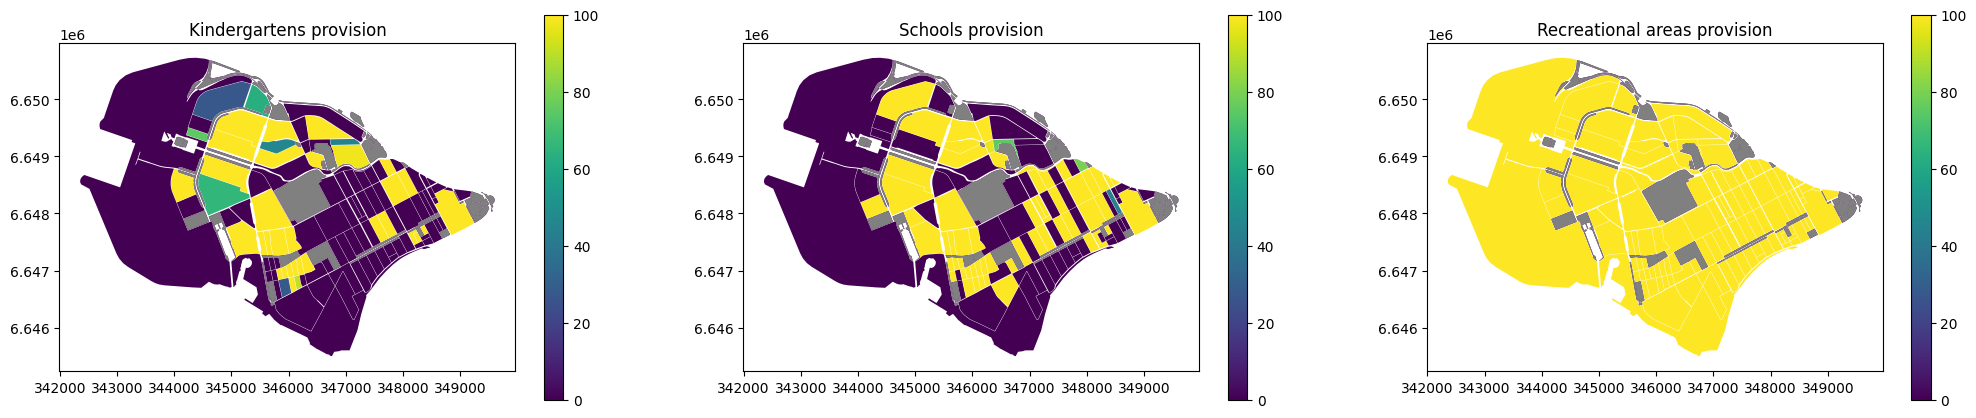

In [16]:
kindergartens_prov_nev = services_prov_nev["kindergartens"]
schools_prov_nev = services_prov_nev["schools"]
recreational_areas_prov_nev = services_prov_nev["recreational_areas"]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
kindergartens_prov_nev.plot(column="provision_kindergartens", legend=True, ax=ax1)
ax1.set_title("Kindergartens provision")
schools_prov_nev.plot(column="provision_schools", legend=True, ax=ax2)
ax2.set_title("Schools provision")
recreational_areas_prov_nev.plot(column="provision_recreational_areas", legend=True, ax=ax3)
ax3.set_title("Recreational areas provision")

kindergartens_prov_nev[kindergartens_prov_nev["population"] == 0].plot(ax=ax1, color="grey", alpha=1)
schools_prov_nev[schools_prov_nev["population"] == 0].plot(ax=ax2, color="grey", alpha=1)
recreational_areas_prov_nev[recreational_areas_prov_nev["population"] == 0].plot(ax=ax3, color="grey", alpha=1)

plt.show()

#### Comparison of service provision before and after the territory change

In [17]:
display("Results of calculating the provision of the kindergarten service for a single block")
display("Before")
display(services_prov["kindergartens"].iloc[24])
display("After")
display(services_prov_nev["kindergartens"].iloc[24])
display("Results of calculating the provision of the recreational_areas service for a single block")
display("Before")
display(services_prov["schools"].iloc[24])
display("After")
display(services_prov_nev["schools"].iloc[24])
display("Results of calculating the provision of the recreational_areas service for a single block")
display("Before")
display(services_prov["recreational_areas"].iloc[24])
display("After")
display(services_prov_nev["recreational_areas"].iloc[24])

'Results of calculating the provision of the kindergarten service for a single block'

'Before'

id                                                                                24
geometry                           POLYGON ((344426.35412361793 6650019.612956254...
provision_kindergartens                                                           15
population_prov_kindergartens                                                   2229
population_unprov_kindergartens                                                12194
population                                                                     14424
Name: 24, dtype: object

'After'

id                                                                                24
geometry                           POLYGON ((344426.35412361793 6650019.612956254...
provision_kindergartens                                                           27
population_prov_kindergartens                                                   5180
population_unprov_kindergartens                                                13626
population                                                                     18807
Name: 24, dtype: object

'Results of calculating the provision of the recreational_areas service for a single block'

'Before'

id                                                                          24
geometry                     POLYGON ((344426.35412361793 6650019.612956254...
provision_schools                                                           19
population_prov_schools                                                   2758
population_unprov_schools                                                11665
population                                                               14424
Name: 24, dtype: object

'After'

id                                                                          24
geometry                     POLYGON ((344426.35412361793 6650019.612956254...
provision_schools                                                          100
population_prov_schools                                                  18807
population_unprov_schools                                                    0
population                                                               18807
Name: 24, dtype: object

'Results of calculating the provision of the recreational_areas service for a single block'

'Before'

id                                                                                     24
geometry                                POLYGON ((344426.35412361793 6650019.612956254...
provision_recreational_areas                                                          100
population_prov_recreational_areas                                                  14424
population_unprov_recreational_areas                                                    0
population                                                                          14424
Name: 24, dtype: object

'After'

id                                                                                     24
geometry                                POLYGON ((344426.35412361793 6650019.612956254...
provision_recreational_areas                                                          100
population_prov_recreational_areas                                                  18806
population_unprov_recreational_areas                                                    0
population                                                                          18807
Name: 24, dtype: object